In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

from PIL import Image #Pillow -- default image backend supported by TorchVision

import cv2

In [2]:
#Define class names - re: PyTorch docs
COCO_INSTANCE_CATEGORY_NAMES = ['bottle', 'sports ball ', '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


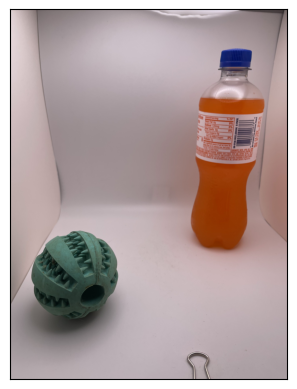

In [4]:
# Read image with cv2 
img = cv2.imread(img_path) 

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as F


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

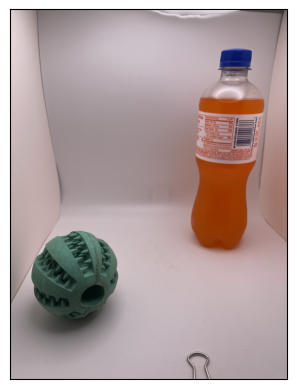

In [6]:
from torchvision.utils import make_grid
from torchvision.io import read_image
from pathlib import Path

bottle_int = read_image(str(img_path))
bottle_list = [bottle_int]

grid = make_grid(bottle_list)
show(grid)

In [7]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in bottle_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

output = model(images)
print(output)

[{'boxes': tensor([[1952.4198,  413.9869, 2773.1587, 2641.8259],
        [  99.8397,  447.8112, 2956.5857, 3944.9978],
        [ 222.9886, 2430.7949, 1166.8607, 3366.4595],
        [1951.3777, 1213.4744, 2666.1963, 2612.2424],
        [ 210.7864, 2357.8589, 1215.4137, 3377.0291],
        [  59.7677,   17.9423,  900.4754, 3375.5925]],
       grad_fn=<StackBackward0>), 'labels': tensor([44, 67, 37, 86, 53, 49]), 'scores': tensor([0.9960, 0.6897, 0.6048, 0.4417, 0.0875, 0.0509],
       grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,

In [8]:
from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT
transforms = weights.transforms()

images = [transforms(d) for d in bottle_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()


batch = torch.stack([transforms(d) for d in bottle_list])


In [9]:
#output = model(batch)
#output
#print(output.shape, output.min().item(), output.max().item())

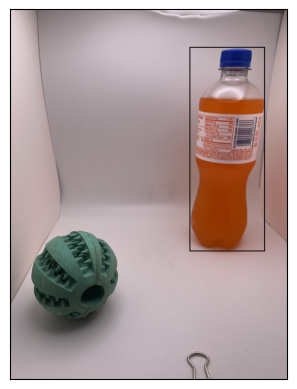

In [10]:
score_threshold = .8
bottle_with_boxes = [
    utils.draw_bounding_boxes(dog_int, boxes=output['boxes'][output['scores'] > score_threshold], width=10)
    for dog_int, output in zip(bottle_list, output)
]
show(bottle_with_boxes)

In [11]:
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights

weights = FCN_ResNet50_Weights.DEFAULT
transforms = weights.transforms(resize_size=None)

model = fcn_resnet50(weights=weights, progress=False)
model = model.eval()

batch = torch.stack([transforms(d) for d in bottle_list])
output = model(batch)['out']
print(output.shape, output.min().item(), output.max().item())

torch.Size([1, 21, 4032, 3024]) -5.316633224487305 15.646990776062012


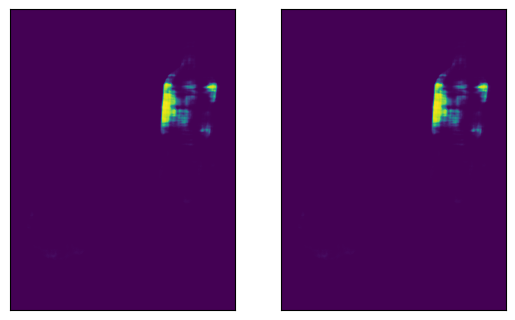

In [12]:
sem_class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

normalized_masks = torch.nn.functional.softmax(output, dim=1)

bottle_masks = [
    normalized_masks[img_idx, sem_class_to_idx[cls]]
    for img_idx in range(len(bottle_list))
    for cls in ('bottle', 'bottle')
]

show(bottle_masks)

shape = torch.Size([1, 4032, 3024]), dtype = torch.bool


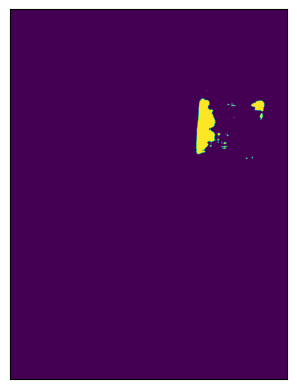

In [13]:
class_dim = 1
boolean_bottle_masks = (normalized_masks.argmax(class_dim) == sem_class_to_idx['bottle'])
print(f"shape = {boolean_bottle_masks.shape}, dtype = {boolean_bottle_masks.dtype}")
show([m.float() for m in boolean_bottle_masks])

In [4]:
img_path = "project_object_data/train/both/IMG_6249.jpg"
threshold=0.25

from torchvision.models.detection import maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights

weights = MaskRCNN_ResNet50_FPN_Weights.DEFAULT

#transforms = weights.transforms()

#images = [transforms(d) for d in bottle_list]

model = maskrcnn_resnet50_fpn(weights=weights, progress=False)
model = model.eval()

In [5]:
# prep image
img = Image.open(img_path)
transform = transforms.ToTensor()
#transform = transforms.Compose([transforms.ToTensor()])
img = transform(img)

In [6]:
#predict
pred = model([img])

pred[0]

# pred_class = [COCO_INSTANCE_CATEGORY_NAMES[i] for i in list(pred[0]['labels'].numpy())]
# pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().numpy())]
# pred_score = list(pred[0]['scores'].detach().numpy())
# pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
# pred_boxes = pred_boxes[:pred_t+1]
# pred_class = pred_class[:pred_t+1]

{'boxes': tensor([[1952.2754,  411.6081, 2773.2690, 2642.3857],
         [  99.9813,  447.3113, 2956.8735, 3945.2871],
         [1951.3447, 1212.7715, 2666.6013, 2612.4045],
         [ 251.9611, 2456.3376, 1155.7350, 3352.6448],
         [ 211.0262, 2362.1748, 1215.0281, 3377.0544],
         [  59.9138,   17.4563,  901.5207, 3375.5007]],
        grad_fn=<StackBackward0>),
 'labels': tensor([44, 67, 86, 37, 53, 49]),
 'scores': tensor([0.9959, 0.6882, 0.4392, 0.3091, 0.0869, 0.0509],
        grad_fn=<IndexBackward0>),
 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
